In [16]:
import numpy as np 
import jax.numpy as jnp
import jax 
import optax
from optax.schedules import warmup_cosine_decay_schedule
import scipy

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt 
import optax

from src.utils import from_timeseries_to_dataset
from src.kernel import TSGaussGaussKernel,VFTSGaussKernel,GaussKernel,VFSGaussKernel,VFTSCauchyKernel,GaussKernel
from src.lddmm import varifold_registration, DeformationGradient,Shooting,Flowing, varifold_time_initializer
from src.plotting import plot2Dfigure   

In [41]:
def gaussian_time_initialization(mu,t_sigma,q0,q0_mask,q1,q1_mask): 
    i0 = q0[:,:1][q0_mask]
    i1 = q1[:,:1][q1_mask]
    pi0 = i1[0] + (i0-i0[0])/(i0[-1]-i0[0])*(i1[-1] - i1[0])
    K = np.exp(-(i0[None,:]-i0[:,None])**2/t_sigma**2)
    f = lambda x : np.sum((mu*np.dot(K, x)-(pi0-i0))**2)
    jac = lambda x : 2*np.dot(K.T,np.dot(K,x)-(pi0-i0))
    hess = 2* K.T@K 
    t_p = scipy.optimize.minimize(f,np.zeros_like(i0),jac=jac,hess=hess,tol=1e-6)["x"]
    p = np.zeros_like(q0)
    p[:t_p.shape[0],0] = t_p
    return p

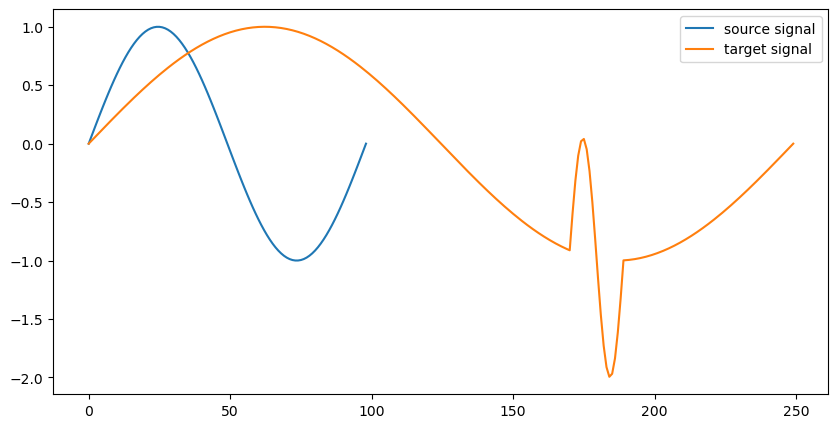

In [30]:
t_sig = np.sin(np.linspace(0,1,250)*2*np.pi)
t_sig[170:190] += 1*np.sin(np.linspace(0,1,20)*2*np.pi)
t_sig = t_sig.reshape(-1,1)
s_sig = np.vstack((np.sin(np.linspace(0,0.5,50)*2*np.pi).reshape(-1,1)[:-1],np.sin(np.linspace(0.5,1,50)*2*np.pi).reshape(-1,1)))

plt.figure(figsize=(10,5))
plt.plot(s_sig, label="source signal")
plt.plot(t_sig,label = "target signal")
plt.legend()

In [39]:
X,mask = from_timeseries_to_dataset([s_sig,t_sig])
s_emb,t_emb = list(zip(X,mask))

In [45]:
gaussian_time_initialization(1,1,s_emb[0],s_emb[1],t_emb[0],t_emb[1])

/tmp/ipykernel_941497/1186362257.py:9: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  t_p = scipy.optimize.minimize(f,np.zeros_like(i0),jac=jac,hess=hess,tol=1e-6)["x"]


array([[ -0.40771067,   0.        ],
       [  1.023677  ,   0.        ],
       [  1.6814013 ,   0.        ],
       [  2.6286635 ,   0.        ],
       [  3.4691648 ,   0.        ],
       [  4.3489537 ,   0.        ],
       [  5.2142906 ,   0.        ],
       [  6.084942  ,   0.        ],
       [  6.9536414 ,   0.        ],
       [  7.823056  ,   0.        ],
       [  8.692207  ,   0.        ],
       [  9.561455  ,   0.        ],
       [ 10.430669  ,   0.        ],
       [ 11.299896  ,   0.        ],
       [ 12.16911   ,   0.        ],
       [ 13.038334  ,   0.        ],
       [ 13.907566  ,   0.        ],
       [ 14.776781  ,   0.        ],
       [ 15.646015  ,   0.        ],
       [ 16.515228  ,   0.        ],
       [ 17.384453  ,   0.        ],
       [ 18.253674  ,   0.        ],
       [ 19.122892  ,   0.        ],
       [ 19.992123  ,   0.        ],
       [ 20.861345  ,   0.        ],
       [ 21.730562  ,   0.        ],
       [ 22.599796  ,   0.        ],
 

Time initialization
iteration:  1 / 400  -- loss:  873.29
iteration:  10 / 400  -- loss:  799.49
iteration:  20 / 400  -- loss:  666.59
iteration:  30 / 400  -- loss:  554.37
iteration:  40 / 400  -- loss:  380.27
iteration:  50 / 400  -- loss:  225.31
iteration:  60 / 400  -- loss:  236.07
iteration:  70 / 400  -- loss:  199.46
iteration:  80 / 400  -- loss:  185.89
iteration:  90 / 400  -- loss:  175.07
iteration:  100 / 400  -- loss:  165.01
iteration:  110 / 400  -- loss:  158.23
iteration:  120 / 400  -- loss:  153.93
iteration:  130 / 400  -- loss:  151.18
iteration:  140 / 400  -- loss:  149.33
iteration:  150 / 400  -- loss:  147.97
iteration:  160 / 400  -- loss:  146.86
iteration:  170 / 400  -- loss:  145.89
iteration:  180 / 400  -- loss:  145.00
iteration:  190 / 400  -- loss:  144.17
iteration:  200 / 400  -- loss:  143.38
iteration:  210 / 400  -- loss:  142.64
iteration:  220 / 400  -- loss:  141.94
iteration:  230 / 400  -- loss:  141.29
iteration:  240 / 400  -- loss:

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

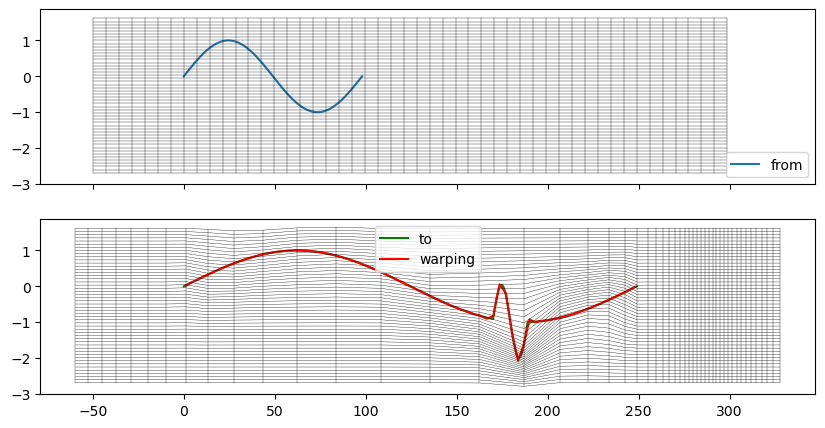

In [46]:
iKv = GaussKernel(100)
Kv = VFTSGaussKernel(1,1,100,1,1)
Kl = TSGaussGaussKernel(2,1,1,1)
shoot = Shooting(Kv)
flow = Flowing(Kv)

init = varifold_time_initializer(iKv,Kl,0,400,optax.adam(warmup_cosine_decay_schedule(0,0.3,40,400,0)),verbose=True)

p,q,qm = varifold_registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],Kv,Kl,p0=init,niter=400,optimizer=optax.adam(warmup_cosine_decay_schedule(0,0.3,40,400,0)),gamma_loss=0.0)
plot2Dfigure(s_emb[0],t_emb[0],p,shoot,flow,s_emb[1],t_emb[1])

iteration:  1 / 1000  -- loss:  873.29
iteration:  10 / 1000  -- loss:  852.71
iteration:  20 / 1000  -- loss:  794.95
iteration:  30 / 1000  -- loss:  636.29
iteration:  40 / 1000  -- loss:  557.38
iteration:  50 / 1000  -- loss:  448.49
iteration:  60 / 1000  -- loss:  362.73
iteration:  70 / 1000  -- loss:  329.49
iteration:  80 / 1000  -- loss:  307.84
iteration:  90 / 1000  -- loss:  279.03
iteration:  100 / 1000  -- loss:  254.46
iteration:  110 / 1000  -- loss:  240.62
iteration:  120 / 1000  -- loss:  237.85
iteration:  130 / 1000  -- loss:  236.57
iteration:  140 / 1000  -- loss:  235.17
iteration:  150 / 1000  -- loss:  234.00
iteration:  160 / 1000  -- loss:  232.89
iteration:  170 / 1000  -- loss:  231.74
iteration:  180 / 1000  -- loss:  230.57
iteration:  190 / 1000  -- loss:  229.38
iteration:  200 / 1000  -- loss:  228.16
iteration:  210 / 1000  -- loss:  226.92
iteration:  220 / 1000  -- loss:  225.68
iteration:  230 / 1000  -- loss:  224.43
iteration:  240 / 1000  -- 

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

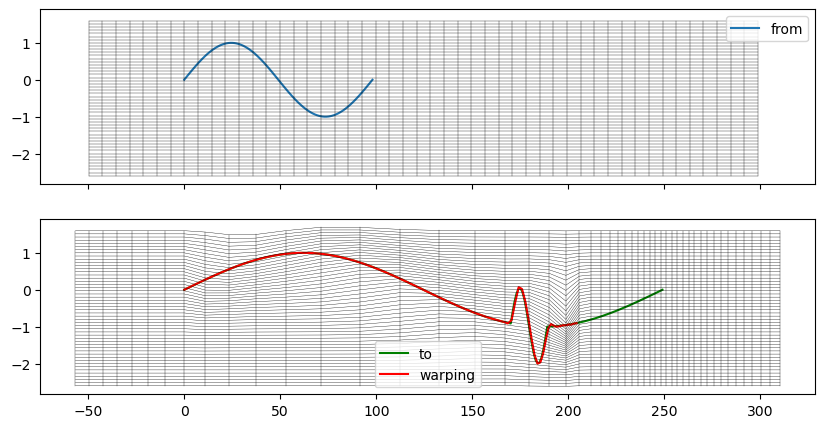

In [48]:
Kv = VFTSGaussKernel(1,0.1,100,1,1)
shoot = Shooting(Kv)
flow = Flowing(Kv)

p,q,qm = varifold_registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],Kv,Kl,niter=1000,optimizer=optax.adabelief(warmup_cosine_decay_schedule(0,0.1,100,1000,0)),gamma_loss=0.0)
plot2Dfigure(s_emb[0],t_emb[0],p,shoot,flow,s_emb[1],t_emb[1])

In [30]:
a = np.ones((10,20,1))
b = np.random.randn(10,20,4)

jnp.concatenate((a,b),axis=-1)[0]

Array([[ 1.        ,  0.50349426, -0.4836543 , -0.42807463,  0.00593435],
       [ 1.        ,  0.48111007, -0.24554174,  0.78136754, -0.65366906],
       [ 1.        ,  0.32946473, -0.00435233, -0.45141807, -0.486978  ],
       [ 1.        , -1.135563  , -0.39268565, -1.4113189 , -0.6340856 ],
       [ 1.        , -0.6565767 , -0.51822585, -2.9683187 , -0.61597186],
       [ 1.        ,  1.9478897 ,  0.39501497,  0.3657377 ,  0.11366013],
       [ 1.        ,  0.06828065, -1.6299025 , -0.9061146 , -1.1885738 ],
       [ 1.        , -0.01001428,  0.27521434,  0.71808386, -0.6822045 ],
       [ 1.        , -1.302478  , -0.92879623,  0.5953338 ,  0.760944  ],
       [ 1.        ,  0.23151019,  0.20383108, -1.3676759 ,  0.84663457],
       [ 1.        ,  0.2615926 ,  0.39325577,  0.152591  , -0.9558284 ],
       [ 1.        , -0.7088961 , -0.22926322, -0.05139887, -0.072366  ],
       [ 1.        ,  0.8132815 ,  0.68121284,  0.02687189, -0.15338731],
       [ 1.        , -0.02742781,  0.3